# Effective Pandas
Starting from Chapter 22, and progressing until the notebook length becomes challenging.  Likely 100 cells of code across a the notebook.  Initiate notebook with data sets being leveraged in prior notebooks to facilitate continuation.

- Car data notebook with mpg data
- World cup history datasource
- Snow resort precipitation records
- Siena President evaluation data
- Jetbrains survey data

### Imports
Minimum imports to follow allong are pandas and numpy.  Potential to add matplotlib at a later point.  Unclear if this is needed at this time.

### Tweak Functions
Functions developed previously to optimize data will be leveraged to reset existing data to lower memory usage systems leveraging changins system used in Chapter 21.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import catboost as cb
import collections

Bad value in file WindowsPath('C:/Users/KNHOFFM/.matplotlib/stylelib/xom.mplstyle'), line 11 ('lines.color: #0C479D'): Key lines.color: '' does not look like a color arg
Bad value in file WindowsPath('C:/Users/KNHOFFM/.matplotlib/stylelib/xom.mplstyle'), line 15 ('patch.edgecolor: #FFFFFF'): Key patch.edgecolor: '' does not look like a color arg
Bad value in file WindowsPath('C:/Users/KNHOFFM/.matplotlib/stylelib/xom.mplstyle'), line 16 ('patch.facecolor: #0C479D'): Key patch.facecolor: '' does not look like a color arg


### Datasets

In [2]:
cars = pd.read_csv("vehicles.csv")

c:\users\knhoffm\.virtualenvs\python_for_engineer_science\lib\site-packages\IPython\core\interactiveshell.py:3378: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
fifa = pd.read_csv("international_matches.csv")

In [4]:
alta_df = pd.read_csv('alta-noaa-1980-2019.csv')

In [5]:
pres_df = pd.read_csv('siena2018-pres.csv', index_col=0)

In [6]:
jb = pd.read_csv('2020-jetbrains-python-survey.csv') # normally pursue url

c:\users\knhoffm\.virtualenvs\python_for_engineer_science\lib\site-packages\IPython\core\interactiveshell.py:3378: DtypeWarning: Columns (152) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Tweak Dataset optimization
Pulled from prior sessions to prep datasets in advance of further analysis and interogation.  This will be pulled where already developed and loaded into this notebook.
- World Cup data set
- Siena Presidents
- Jetbrains survey

### JetBrains Dataset tweak
---

In [7]:
def get_uniu_cols(jb): 
    # jb here is to help see the passed data, but not technically require as it confuses the name space
    '''This function is unique to this data set due to the field structure using periods and having duplicate fields.
    It strips out the variants of a column, and targets the root fields for the dataset'''
    counter = collections.defaultdict(list)
    for col in sorted(jb.columns):
        period_count = col.count('.')
        if period_count >= 2:
            part_end = 2
        else:
            part_end = 1
        parts = col.split('.')[:part_end]
        counter['.'.join(parts)].append(col)
    uniq_cols = []
    for cols in counter.values():
        if len(cols) == 1:
            uniq_cols.extend(cols)
    return uniq_cols

In [8]:
def prep_for_ml(df):
    # remove pandas specific dtypes
    '''Specifically done to help with the use of catboost, which requires base Python types'''
    return (df
            .assign(**{col:df[col].astype(float) for col in df.select_dtypes('number')},
                    **{col:df[col].astype(str).fillna('') for col in df.select_dtypes(['object', 'category'])})
           )

In [9]:
def predict_col(df, col):
    '''leverages the prep_for_ml return value to conduct prediction on the series and return a series with
    missing data imputed based on the prediction engine'''
    df = prep_for_ml(df)
    missing = df.query(f'~{col}.isna()')
    cat_idx = []
    for i, typ in enumerate(df.drop(columns=[col]).dtypes):
        if str(typ) == 'object':
            cat_idx.append(i)
    X = (missing.drop(columns=[col]).values)
    y = missing[col]
    model = cb.CatBoostRegressor(iterations=20, cat_features=cat_idx)
    model.fit(X, y, cat_features=cat_idx)
    pred = model.predict(df.drop(columns=[col]))
    return df[col].where(~df[col].isna(), pred)

In [10]:
def tweak_jb(jb):
    '''Full clean up and modification of jb dataframe from jetbrains survey response'''
    uniq_cols = get_uniu_cols(jb)
    return (jb
            [uniq_cols]
            .rename(columns=lambda c:c.replace('.','_'))
            .assign(age = lambda df_:df_.age.str[:2].astype(float).astype('Int64'),
                    are_you_datascientist = lambda df_: df_.are_you_datascientist
                        .replace({'Yes':True,'No':False,np.nan:False}),
                    company_size = lambda df_:df_.company_size.replace({'51–500':51,'More than 5,000':5000,
                        '11–50':11,'2–10':2,'1,001–5,000':1001,'Just me':1,'501–1,000':501,'Not sure':np.nan})
                        .astype('Int64'),
                    country_live = lambda df_:df_.country_live.astype('category'),
                    employment_status = lambda df_:df_.employment_status.fillna('Other').astype('category'),
                    is_python_main = lambda df_:df_.is_python_main.astype('category'),
                    team_size = lambda df_: df_.team_size.str.split(r'-', n=1, expand=True)
                        .iloc[:,0].replace('More than 40 people',41)
                        .where(df_.company_size!=1, 1).astype(float),
                    years_of_coding = lambda df_: df_.years_of_coding.replace('Less than 1 year',0.5)
                        .str.extract(r'(\d+)').astype(float),
                    python3_ver = lambda df_:df_.python3_version_most.str.replace('_','.')
                        .str.extract(r'(\d\.\d)').astype(float),
                    use_python_most = lambda df_: df_.use_python_most.fillna('Unknown')
                   )
            .assign(team_size = lambda df_: predict_col(df_, 'team_size').astype(int))
            .drop(columns=['python2_version_most'])
            .dropna()
           )

In [11]:
jb = tweak_jb(jb)

Learning rate set to 0.5
0:	learn: 2.9835208	total: 219ms	remaining: 4.16s
1:	learn: 2.8774954	total: 260ms	remaining: 2.34s
2:	learn: 2.8394639	total: 300ms	remaining: 1.7s
3:	learn: 2.8050221	total: 335ms	remaining: 1.34s
4:	learn: 2.7869339	total: 369ms	remaining: 1.11s
5:	learn: 2.7743464	total: 402ms	remaining: 938ms
6:	learn: 2.7620047	total: 440ms	remaining: 817ms
7:	learn: 2.7579574	total: 477ms	remaining: 716ms
8:	learn: 2.7499983	total: 510ms	remaining: 624ms
9:	learn: 2.7459189	total: 545ms	remaining: 545ms
10:	learn: 2.7455531	total: 581ms	remaining: 476ms
11:	learn: 2.7417426	total: 614ms	remaining: 409ms
12:	learn: 2.7409715	total: 647ms	remaining: 349ms
13:	learn: 2.7397709	total: 685ms	remaining: 294ms
14:	learn: 2.7329598	total: 722ms	remaining: 241ms
15:	learn: 2.7271657	total: 757ms	remaining: 189ms
16:	learn: 2.7223690	total: 790ms	remaining: 139ms
17:	learn: 2.7209157	total: 822ms	remaining: 91.3ms
18:	learn: 2.7162403	total: 856ms	remaining: 45ms
19:	learn: 2.7135

### Siena Dataset tweak
---

In [12]:
def tweak_siena(df):
    """Convert Siena presidential Dataframe into a more usable format with appropriate dtypes"""
    def int64_to_uint8(df_):
        """convert int columns to uint8 dtype for space/memory"""
        cols = df_.select_dtypes('int64')
        return (df_
                .astype({col:'uint8' for col in cols})
               )
    return (df
            .rename(columns={'Seq.':'Seq'}) #1 column name update
            .rename(columns={k:v.replace(' ','_') for k,v in
                {'Bg':'Background',
                 'PL':'Party Leadership','CAb':'Communication ability',
                 'RC':'Relations with Congress','CAp':'Court appointments',
                 'HE':'Handling of economy','L':'Luck',
                 'AC':'Ability to compromise','WR':'Willing to take risks',
                 'EAp':'Executive appointments','OA':'Overall Ability',
                 'Im':'Imagination','DA':'Domestic accomplishments',
                 'Int':'Integrity','EAb':'Executive ability',
                 'FPA':'Foriegn policy accomplishments',
                 'LA':'Leadership ability',
                 'IQ':'Intelligence','AM':'Avoid crucial mistakes',
                 'EV':'Experts view','O':'Overall'}.items()})
            .astype({'Party':'category'}) #2 category convert
            .pipe(int64_to_uint8) #3 dtypes
            .assign(Average_rank=lambda df_:(df_.select_dtypes('uint8') #4 create new columns
                            .sum(axis=1).rank(method='dense').astype('uint8')),
                   Quartile=lambda df_:pd.qcut(df_.Average_rank, 4,
                        labels='Ist 2nd 3rd 4th'.split())
                   )
           )

In [13]:
pres = tweak_siena(pres_df)

### Fifa Dataset Tweak
---

In [14]:
def tweak_fifa(fifa):
    return (fifa
            .assign(date = lambda df_:pd.to_datetime(df_.date),
                    home_team = lambda df_:df_.home_team.astype('category'),
                    away_team = lambda df_:df_.away_team.astype('category'),
                    home_team_continent = lambda df_:df_.home_team_continent.astype('category'),
                    away_team_continent = lambda df_:df_.away_team_continent.astype('category'),
                    home_team_fifa_rank = lambda df_:df_.home_team_fifa_rank.astype('int32'),
                    away_team_fifa_rank = lambda df_:df_.away_team_fifa_rank.astype('int32'),
                    home_team_total_fifa_points = lambda df_:df_.home_team_total_fifa_points.astype('int32'),
                    away_team_total_fifa_points = lambda df_:df_.away_team_total_fifa_points.astype('int32'),
                    home_team_score = lambda df_:df_.home_team_score.astype('int8'),
                    away_team_score = lambda df_:df_.away_team_score.astype('int8'),
                    tournament = lambda df_:df_.tournament.astype('category'),
                    city = lambda df_:df_.city.astype('category'),
                    country = lambda df_:df_.country.astype('category'),
                    shoot_out = lambda df_: df_.shoot_out.where(df_.shoot_out=='Yes',True).where(df_.shoot_out=='No',False),
                    home_team_result = lambda df_:df_.home_team_result.astype('category'))
           )

In [15]:
fifa = tweak_fifa(fifa)

## Chapter 22 - Missing and Duplicated data
Missing data is a reality we must account for in collected information.  For a large number of reasons data will come across incomplete, requiring decisions regarding keep and imputing or removing the information.  This issue becomes even more critical in the world of machine learning where algorithms often will not run with missing data.

### Missing data
The first and most important step is finding missing data.  This can be accomadated a number of ways, but the focus will remain in the bare pandas functionality for the library.  Much like a series, the process is the same for a Dataframe.  The first method to leverage is .isna().  This will return a boolean array indicating where there are missing values.

In [16]:
pres.isna()

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
pres[pres.Integrity.isna()] # nothing missing

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile


In [18]:
# check the whole frame even if large, all zeros means no missing data
pres.isna().sum()

Seq                               0
President                         0
Party                             0
Background                        0
Imagination                       0
Integrity                         0
Intelligence                      0
Luck                              0
Willing_to_take_risks             0
Ability_to_compromise             0
Executive_ability                 0
Leadership_ability                0
Communication_ability             0
Overall_Ability                   0
Party_Leadership                  0
Relations_with_Congress           0
Court_appointments                0
Handling_of_economy               0
Executive_appointments            0
Domestic_accomplishments          0
Foriegn_policy_accomplishments    0
Avoid_crucial_mistakes            0
Experts_view                      0
Overall                           0
Average_rank                      0
Quartile                          0
dtype: int64

In [19]:
# take the mean to get the fraction missing
pres.isna().mean()

Seq                               0.0
President                         0.0
Party                             0.0
Background                        0.0
Imagination                       0.0
Integrity                         0.0
Intelligence                      0.0
Luck                              0.0
Willing_to_take_risks             0.0
Ability_to_compromise             0.0
Executive_ability                 0.0
Leadership_ability                0.0
Communication_ability             0.0
Overall_Ability                   0.0
Party_Leadership                  0.0
Relations_with_Congress           0.0
Court_appointments                0.0
Handling_of_economy               0.0
Executive_appointments            0.0
Domestic_accomplishments          0.0
Foriegn_policy_accomplishments    0.0
Avoid_crucial_mistakes            0.0
Experts_view                      0.0
Overall                           0.0
Average_rank                      0.0
Quartile                          0.0
dtype: float

In [20]:
(cars
 [['make','year','cylinders','drive']]
 .isna()
 .sum() # count missing
#  .mean().mul(100) # percent missing
) 

make            0
year            0
cylinders     456
drive        1186
dtype: int64

### Acting on missing data
Once the missing data is located, the next logical question is what is the best way to handle the missing records.  There a handful of immediate values which can be leveraged.
- dropna(): removing the rows, but should only be used sparingly
- fillna(): lots of options to populate the data (FF, BF, etc)
- interpolate(): averaging the before and after values. Should be time series or something on a continuous scale

All of these options can be somewhat heavy handed in addressing missing data on an entire dataframe since the information in different fields may be present on the same record.  Generally these should be used on an individual series, leveraging the .assign() method in conjuction with the chosen approach.  

In [21]:
(cars
 [['make','model','year','cylinders','drive']]
 .query('drive.isna()')
#  .assign(cylinders = lambda df_:df_.cylinders.fillna('EV'),
#          drive = lambda df_:df_.drive.dropna())
#  .query('cylinders=="EV"')
)

,make,model,year,cylinders,drive
7138,Nissan,Altra EV,2000,NaN,NaN
8144,Ford,Th!nk,2001,NaN,NaN
8147,Nissan,Hyper-Mini,2001,NaN,NaN
18214,Alfa Romeo,Spider Veloce 2000,1984,4.0,NaN
18215,Bertone,X1/9,1984,4.0,NaN
...,...,...,...,...,...
23019,GMC,EV1,1999,NaN,NaN
23020,GMC,EV1,1999,NaN,NaN
23022,Honda,EV Plus,1999,NaN,NaN
23027,Honda,EV Plus,1998,NaN,NaN


### Duplicates
While missing data is critical to get corrected, duplicates can result in code that executes but is provide the wrong answer to  the question.  Duplicated data can be harder to location, making it even more nefarious in the overall EDA and modeling pipeline.

The .drop_duplicates() method works, but it can be a very blunt approach.  Thankfully, there is a parameter called subset which allows finer control over how the method is applied.

In [22]:
pres.drop_duplicates() # because it is checking the entire record, this call does nothing

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
1,1,George Washington,Independent,7,7,1,10,1,6,2,...,1,1,1,2,2,1,2,1,1,Ist
2,2,John Adams,Federalist,3,13,4,4,24,14,31,...,4,13,15,19,13,16,10,14,13,2nd
3,3,Thomas Jefferson,Democratic-Republican,2,2,14,1,8,5,14,...,7,20,4,6,9,7,5,5,5,Ist
4,4,James Madison,Democratic-Republican,4,6,7,3,16,15,6,...,6,14,7,11,19,11,8,7,7,Ist
5,5,James Monroe,Democratic-Republican,9,14,11,18,6,16,7,...,11,9,9,10,5,6,9,8,8,Ist
6,6,John Quincy Adams,Democratic-Republican,1,9,6,5,29,19,24,...,15,17,18,21,15,14,18,18,18,2nd
7,7,Andrew Jackson,Democratic,37,15,29,28,4,4,38,...,30,25,25,17,23,20,19,19,19,2nd
8,8,Martin Van Buren,Democratic,23,22,27,25,34,28,20,...,25,31,26,29,27,24,28,25,25,3rd
9,9,William Henry Harrison,Whig,22,38,28,37,44,32,41,...,42,41,40,42,44,37,39,39,38,4th
10,10,John Tyler,Independent,34,33,35,34,22,26,37,...,38,34,36,36,26,32,36,37,37,4th


In [23]:
pres.drop_duplicates(subset='Party') # first president for each party

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
1,1,George Washington,Independent,7,7,1,10,1,6,2,...,1,1,1,2,2,1,2,1,1,Ist
2,2,John Adams,Federalist,3,13,4,4,24,14,31,...,4,13,15,19,13,16,10,14,13,2nd
3,3,Thomas Jefferson,Democratic-Republican,2,2,14,1,8,5,14,...,7,20,4,6,9,7,5,5,5,Ist
7,7,Andrew Jackson,Democratic,37,15,29,28,4,4,38,...,30,25,25,17,23,20,19,19,19,2nd
9,9,William Henry Harrison,Whig,22,38,28,37,44,32,41,...,42,41,40,42,44,37,39,39,38,4th
16,16,Abraham Lincoln,Republican,28,1,2,2,18,1,1,...,3,4,2,1,6,2,1,3,3,Ist


In [24]:
pres.drop_duplicates(subset='Party', keep='last') # changing from first to last behavior (yields most recent party pres)

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
2,2,John Adams,Federalist,3,13,4,4,24,14,31,...,4,13,15,19,13,16,10,14,13,2nd
6,6,John Quincy Adams,Democratic-Republican,1,9,6,5,29,19,24,...,15,17,18,21,15,14,18,18,18,2nd
10,10,John Tyler,Independent,34,33,35,34,22,26,37,...,38,34,36,36,26,32,36,37,37,4th
13,13,Millard Fillmore,Whig,40,37,36,38,35,38,32,...,39,37,37,37,37,33,37,38,39,4th
43,44,Barack Obama,Democratic,24,11,13,9,15,23,16,...,14,10,13,13,20,10,11,17,17,2nd
44,45,Donald Trump,Republican,43,40,44,44,10,25,42,...,40,39,44,40,42,41,42,42,42,4th


In [25]:
pres.drop_duplicates(subset='Party', keep=False) # Keeps only the first found non duplicated records

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
2,2,John Adams,Federalist,3,13,4,4,24,14,31,...,4,13,15,19,13,16,10,14,13,2nd


### Row by row comparison
To drop duplicates based on the prior row values is a more complex discussion, and requires some additional effort around building a query.

In [26]:
(pres
 .assign(first_in_party_seq = lambda df_: df_.Party != df_.Party.shift(1))
 .loc[lambda df_: df_.first_in_party_seq]
) # removes back to back terms based on shift and then masking dataframe with result

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile,first_in_party_seq
1,1,George Washington,Independent,7,7,1,10,1,6,2,...,1,1,2,2,1,2,1,1,Ist,True
2,2,John Adams,Federalist,3,13,4,4,24,14,31,...,13,15,19,13,16,10,14,13,2nd,True
3,3,Thomas Jefferson,Democratic-Republican,2,2,14,1,8,5,14,...,20,4,6,9,7,5,5,5,Ist,True
7,7,Andrew Jackson,Democratic,37,15,29,28,4,4,38,...,25,25,17,23,20,19,19,19,2nd,True
9,9,William Henry Harrison,Whig,22,38,28,37,44,32,41,...,41,40,42,44,37,39,39,38,4th,True
10,10,John Tyler,Independent,34,33,35,34,22,26,37,...,34,36,36,26,32,36,37,37,4th,True
11,11,James K. Polk,Democratic,19,10,23,23,9,7,18,...,15,16,12,8,8,13,12,11,Ist,True
12,12,Zachary Taylor,Whig,30,26,22,32,37,24,26,...,27,33,27,30,26,30,30,30,3rd,True
14,14,Franklin Pierce,Democratic,38,39,38,40,39,38,39,...,40,39,41,39,38,40,40,41,4th,True
16,16,Abraham Lincoln,Republican,28,1,2,2,18,1,1,...,4,2,1,6,2,1,3,3,Ist,True


### Psets
With a dataset of you own:
1. Find which columns have missing data
2. Count missing values for each column
3. Find the percentage of missing vals for each column
4. Find the rows with missing data
5. Find the rows with duplicated data

In [27]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           23921 non-null  datetime64[ns]
 1   home_team                      23921 non-null  category      
 2   away_team                      23921 non-null  category      
 3   home_team_continent            23921 non-null  category      
 4   away_team_continent            23921 non-null  category      
 5   home_team_fifa_rank            23921 non-null  int32         
 6   away_team_fifa_rank            23921 non-null  int32         
 7   home_team_total_fifa_points    23921 non-null  int32         
 8   away_team_total_fifa_points    23921 non-null  int32         
 9   home_team_score                23921 non-null  int8          
 10  away_team_score                23921 non-null  int8          
 11  tournament     

In [28]:
(fifa
 .iloc[:,17:]
 .isna()
 .mean().mul(100)
)

home_team_goalkeeper_score       64.972200
away_team_goalkeeper_score       66.159441
home_team_mean_defense_score     67.447013
home_team_mean_offense_score     64.424564
home_team_mean_midfield_score    65.879353
away_team_mean_defense_score     68.379248
away_team_mean_offense_score     65.252289
away_team_mean_midfield_score    66.644371
dtype: float64

In [29]:
(fifa
 .assign(missing = lambda df_: df_.isna().any(axis=1))
 .loc[lambda df_:df_.missing > 0]
)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,missing
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,...,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN,True
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN,True
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0,True


In [30]:
fifa.drop_duplicates(subset='tournament').tournament

0                FIFA World Cup qualification
1                                    Friendly
13       African Cup of Nations qualification
143                        Amílcar Cabral Cup
183           CFU Caribbean Cup qualification
                         ...                 
21440                 CONCACAF Nations League
22850                       Three Nations Cup
23164                   Mahinda Rajapaksa Cup
23535                              Navruz Cup
23653          CONMEBOL–UEFA Cup of Champions
Name: tournament, Length: 82, dtype: category
Categories (82, object): ['ABCS Tournament', 'AFC Asian Cup', 'AFC Asian Cup qualification', 'AFC Challenge Cup', ..., 'United Arab Emirates Friendship Tournament', 'VFF Cup', 'WAFF Championship', 'Windward Islands Tournament']

## Ch 23 Sorting Columns and Indexes
There are a number of ways to approach sorting data.  This can be done through the original indexing or by fields available in the data that is loaded.  Depending on the information available you can sort alphabetically, numerically, by group affiliation, or other data type.

### Sorting Columns (fields)
This is the first and most apparent approach.  Here we leverage the .sort_values() method to interogate a series and sort that series, and the rest of our data, by the series value order specified. This can also be done across mulitple fields with specified order for each.

In [31]:
(pres
 .sort_values(by=['Party','Average_rank'], ascending=[True, False])
)

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
17,17,Andrew Johnson,Democratic,42,42,41,42,40,34,43,...,44,43,42,43,41,43,43,44,44,4th
15,15,James Buchanan,Democratic,36,43,40,39,42,41,40,...,43,42,43,44,43,44,44,43,43,4th
14,14,Franklin Pierce,Democratic,38,39,38,40,39,38,39,...,41,40,39,41,39,38,40,40,41,4th
38,39,Jimmy Carter,Democratic,25,19,3,15,38,27,29,...,19,38,22,28,25,34,26,26,27,3rd
8,8,Martin Van Buren,Democratic,23,22,27,25,34,28,20,...,25,31,26,29,27,24,28,25,25,3rd
22,22/24,Grover Cleveland,Democratic,26,23,26,27,19,27,22,...,20,21,23,23,21,15,22,23,23,3rd
7,7,Andrew Jackson,Democratic,37,15,29,28,4,4,38,...,30,25,25,17,23,20,19,19,19,2nd
43,44,Barack Obama,Democratic,24,11,13,9,15,23,16,...,14,10,13,13,20,10,11,17,17,2nd
35,36,Lyndon B. Johnson,Democratic,15,11,34,22,25,10,9,...,8,12,8,5,40,35,17,16,16,2nd
41,42,Bill Clinton,Democratic,21,12,39,8,11,17,3,...,10,5,12,9,18,30,14,15,15,2nd


### Sort_values() with key
The sort_values() options also allows the user to provide a specific key to sort the information.  This essentially allows a function to be passed to the sorting function to apply some form of addition logic to the sorting algorithm.  

In [32]:
(pres
 .sort_values(by='President', 
              key= lambda name_ser: name_ser.str.split().apply(lambda val:val[-1]))
 # passing President to str.split() converts to a list, passing the list to pull the last value, val[-1]
)

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
2,2,John Adams,Federalist,3,13,4,4,24,14,31,...,4,13,15,19,13,16,10,14,13,2nd
6,6,John Quincy Adams,Democratic-Republican,1,9,6,5,29,19,24,...,15,17,18,21,15,14,18,18,18,2nd
21,21,Chester A. Arthur,Republican,41,31,37,36,17,33,22,...,33,30,31,25,32,23,31,34,34,4th
15,15,James Buchanan,Democratic,36,43,40,39,42,41,40,...,43,42,43,44,43,44,44,43,43,4th
8,8,Martin Van Buren,Democratic,23,22,27,25,34,28,20,...,25,31,26,29,27,24,28,25,25,3rd
40,41,George H. W. Bush,Republican,10,27,18,19,20,27,13,...,29,28,19,26,10,17,21,21,21,2nd
42,43,George W. Bush,Republican,17,29,33,41,21,20,28,...,28,36,29,30,38,36,34,33,33,3rd
38,39,Jimmy Carter,Democratic,25,19,3,15,38,27,29,...,19,38,22,28,25,34,26,26,27,3rd
22,22/24,Grover Cleveland,Democratic,26,23,26,27,19,27,22,...,20,21,23,23,21,15,22,23,23,3rd
41,42,Bill Clinton,Democratic,21,12,39,8,11,17,3,...,10,5,12,9,18,30,14,15,15,2nd


### Sorting Column order
Reordering the columns can be accomadated through a call to sort_index() with the appropriate axis.  This is infrequently leveraged to managed DataFrame since information is accessed via keys more often.

In [33]:
(pres
 .sort_index(axis='columns', key= lambda cols:cols.str[::-1])
 # sorting by column names backwards?? It worked
)

,Background,Intelligence,Quartile,Ability_to_compromise,Luck,Average_rank,Overall,Imagination,Party_Leadership,Seq,...,Court_appointments,President,Experts_view,Handling_of_economy,Overall_Ability,Executive_ability,Communication_ability,Leadership_ability,Integrity,Party
1,7,10,Ist,2,1,1,1,7,18,1,...,1,George Washington,2,1,2,2,11,1,1,Independent
2,3,4,2nd,31,24,13,14,13,28,2,...,4,John Adams,10,13,8,21,13,21,4,Federalist
3,2,1,Ist,14,8,5,5,2,5,3,...,7,Thomas Jefferson,5,20,4,6,4,6,14,Democratic-Republican
4,4,3,Ist,6,16,7,7,6,9,4,...,6,James Madison,8,14,6,13,10,17,7,Democratic-Republican
5,9,18,Ist,7,6,8,8,14,12,5,...,11,James Monroe,9,9,17,10,15,12,11,Democratic-Republican
6,1,5,2nd,24,29,18,18,9,29,6,...,15,John Quincy Adams,18,17,16,22,12,23,6,Democratic-Republican
7,37,28,2nd,38,4,19,19,15,6,7,...,30,Andrew Jackson,19,25,19,11,18,9,29,Democratic
8,23,25,3rd,20,34,25,25,22,16,8,...,25,Martin Van Buren,28,31,27,28,25,27,27,Democratic
9,22,37,4th,41,44,38,39,38,36,9,...,42,William Henry Harrison,39,41,37,38,31,29,28,Whig
10,34,34,4th,37,22,37,37,33,41,10,...,38,John Tyler,36,34,36,36,34,37,35,Independent


### Setting and sorting indexes
This is a common practice, most often seen with time series data and dates, but can be leveraged in a number of circumstances.  Select a column to become the index which can be sorted for the output DataFrame. You should always sort the index to ensure slicing operations function as intended, otherwise they will throw key errors.

In [34]:
(pres
 .set_index('President')
 .sort_index()
)

,Seq,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
President,,,,,,,,,,,,,,,,,,,,,
Abraham Lincoln,16,Republican,28,1,2,2,18,1,1,1,...,3,4,2,1,6,2,1,3,3,Ist
Andrew Jackson,7,Democratic,37,15,29,28,4,4,38,11,...,30,25,25,17,23,20,19,19,19,2nd
Andrew Johnson,17,Democratic,42,42,41,42,40,34,43,43,...,44,43,42,43,41,43,43,44,44,4th
Barack Obama,44,Democratic,24,11,13,9,15,23,16,18,...,14,10,13,13,20,10,11,17,17,2nd
Benjamin Harrison,23,Republican,33,34,30,35,28,36,33,35,...,35,32,34,32,29,29,33,35,36,4th
Bill Clinton,42,Democratic,21,12,39,8,11,17,3,16,...,10,5,12,9,18,30,14,15,15,2nd
Calvin Coolidge,30,Republican,32,36,17,33,13,39,27,32,...,31,24,32,33,35,22,32,31,31,3rd
Chester A. Arthur,21,Republican,41,31,37,36,17,33,22,30,...,33,30,31,25,32,23,31,34,34,4th
Donald Trump,45,Republican,43,40,44,44,10,25,42,41,...,40,39,44,40,42,41,42,42,42,4th


In [35]:
(pres
 .set_index('Party')
 .sort_index()
 .loc['Democratic':'Republican'] #slice on sorted string index allows start stop values
)

,Seq,President,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
Party,,,,,,,,,,,,,,,,,,,,,
Democratic,22/24,Grover Cleveland,26,23,26,27,19,27,22,19,...,20,21,23,23,21,15,22,23,23,3rd
Democratic,32,Franklin D. Roosevelt,6,3,16,12,5,3,4,3,...,2,2,3,3,1,4,3,2,2,Ist
Democratic,17,Andrew Johnson,42,42,41,42,40,34,43,43,...,44,43,42,43,41,43,43,44,44,4th
Democratic,33,Harry S. Truman,31,16,9,21,12,8,12,8,...,17,8,10,7,4,9,7,9,9,Ist
Democratic,15,James Buchanan,36,43,40,39,42,41,40,42,...,43,42,43,44,43,44,44,43,43,4th
Democratic,14,Franklin Pierce,38,39,38,40,39,38,39,39,...,41,40,39,41,39,38,40,40,41,4th
Democratic,35,John F. Kennedy,14,5,31,11,31,9,8,12,...,12,7,6,15,17,18,12,10,10,Ist
Democratic,36,Lyndon B. Johnson,15,11,34,22,25,10,9,9,...,8,12,8,5,40,35,17,16,16,2nd
Democratic,11,James K. Polk,19,10,23,23,9,7,18,7,...,22,15,16,12,8,8,13,12,11,Ist


### Pset
With a dataset of your choice
1. Sort the index
2. Set the index to a string column, sort the index and slice by a substring
3. Sort by a single column
4. Sort by two columns
5. Sort by the last letter of a string column

In [36]:
# 1. Sort the index
(fifa
 .sort_index()
)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,True,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,True,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,True,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,...,True,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,True,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,True,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,True,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,False,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,True,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0


In [37]:
# 2. Set the index to a string column, sort the index and slice by a substring
(fifa
 .set_index('tournament')
 .sort_index()
 .loc['FIFA World Cup qualification':'Three Nations Cup']
)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
tournament,,,,,,,,,,,,,,,,,,,,,
FIFA World Cup qualification,2005-09-03,Slovenia,Norway,Europe,Europe,48,36,0,0,2,...,True,Lose,76.0,79.0,72.2,72.3,71.8,80.0,83.7,78.5
FIFA World Cup qualification,2005-09-07,Belgium,San Marino,Europe,Europe,52,161,0,0,8,...,True,Win,74.0,NaN,81.2,79.7,76.2,NaN,NaN,NaN
FIFA World Cup qualification,2005-09-07,Azerbaijan,Austria,Europe,Europe,116,71,0,0,0,...,True,Draw,NaN,83.0,NaN,NaN,NaN,74.8,74.3,69.0
FIFA World Cup qualification,2005-09-07,Kazakhstan,Greece,Europe,Europe,148,18,0,0,1,...,True,Lose,NaN,85.0,NaN,NaN,NaN,78.5,82.3,81.8
FIFA World Cup qualification,2005-10-08,Costa Rica,USA,North America,North America,19,7,0,0,3,...,True,Win,72.0,84.0,69.5,70.0,68.8,77.2,76.7,78.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Superclásico de las Américas,2014-10-11,Argentina,Brazil,South America,South America,2,6,1630,1291,0,...,True,Lose,79.0,82.0,81.2,88.0,82.8,83.8,84.0,82.2
TIFOCO Tournament,2003-03-07,Benin,Niger,Africa,Africa,149,185,0,0,1,...,False,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Three Nations Cup,2021-09-07,Kyrgyz Republic,Bangladesh,Asia,Asia,101,188,1223,909,4,...,True,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# 3. Sort by a single column
# 4. Sort by two columns and set two level index followed by a slice
(fifa
 .sort_values(by=['country','city'])
 .set_index(['country','city'])
 .loc['USA']
)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
city,,,,,,,,,,,,,,,,,,,,,
Albuquerque,1994-04-30,USA,Chile,North America,South America,23,46,0,0,0,...,True,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albuquerque,2005-03-19,USA,Honduras,North America,North America,11,58,0,0,1,...,True,Win,89.0,NaN,78.2,80.0,82.0,NaN,NaN,69.0
Anaheim,1996-01-10,Canada,Honduras,North America,North America,65,49,0,0,3,...,True,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anaheim,1996-01-10,Trinidad and Tobago,El Salvador,South America,North America,57,82,0,0,2,...,True,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anaheim,1996-01-13,USA,Trinidad and Tobago,North America,South America,19,57,0,0,3,...,True,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Washington,2019-06-05,USA,Jamaica,North America,North America,24,56,1506,1391,0,...,True,Lose,75.0,75.0,76.2,76.3,76.8,73.5,68.0,71.5
Washington,2019-10-11,USA,Cuba,North America,North America,21,178,1545,940,7,...,True,Win,76.0,63.0,76.5,74.7,76.8,NaN,NaN,NaN
Washington,2021-09-24,El Salvador,Guatemala,North America,North America,65,123,1369,1138,0,...,True,Lose,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# 5. Sort by the last letter of a string column, using home_team here
(fifa
 .sort_values(by=['home_team'], key=lambda team_name:team_name.str[-1])
 )

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
3508,1999-02-21,USA,Chile,North America,South America,23,20,0,0,2,...,True,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,1994-05-07,USA,Estonia,North America,Europe,23,115,0,0,4,...,True,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8460,2004-10-13,USA,Panama,North America,North America,11,103,0,0,6,...,True,Win,89.0,NaN,78.2,80.0,82.0,NaN,NaN,NaN
1875,1996-11-03,USA,Guatemala,North America,North America,25,116,0,0,2,...,True,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
947,1995-06-25,USA,Colombia,North America,South America,34,23,0,0,0,...,True,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11784,2008-09-09,Paraguay,Venezuela,South America,South America,25,61,0,0,2,...,True,Win,74.0,65.0,75.0,79.7,74.8,NaN,74.7,64.5
22867,2021-09-02,Italy,Bulgaria,Europe,Europe,5,75,1744,1334,1,...,True,Draw,89.0,66.0,84.2,85.3,84.5,67.2,64.3,64.5
5940,2001-10-07,Paraguay,Argentina,South America,South America,11,3,0,0,2,...,True,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5919,2001-10-06,Germany,Finland,Europe,Europe,12,52,0,0,0,...,True,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Ch 24 Filtering and Indexing Ops
Generally it is advised to keep data in the fields and avoid pushing it into the index.  That said, while this is preferred there are valuable use cases for moving data into the index.  The section will evaluate operations to change the index and associted operations that result from a changed index.  It will also demonstrate extracting data out of the index.

### Renaming an Index
The .rename() method is used to update the index.  This method will accept a function that takes the current value and returns a new value.  There are a number of ways to leverage this function to update the index.

In [40]:
def name_to_initial(val):
    names = val.split()
    return " ".join([f'{names[0][0]}.', *names[1:]]) # names [0][0] means first name first letter from the split list 

In [41]:
(pres
 .set_index('President')
 .rename(name_to_initial)
)

,Seq,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
President,,,,,,,,,,,,,,,,,,,,,
G. Washington,1,Independent,7,7,1,10,1,6,2,2,...,1,1,1,2,2,1,2,1,1,Ist
J. Adams,2,Federalist,3,13,4,4,24,14,31,21,...,4,13,15,19,13,16,10,14,13,2nd
T. Jefferson,3,Democratic-Republican,2,2,14,1,8,5,14,6,...,7,20,4,6,9,7,5,5,5,Ist
J. Madison,4,Democratic-Republican,4,6,7,3,16,15,6,13,...,6,14,7,11,19,11,8,7,7,Ist
J. Monroe,5,Democratic-Republican,9,14,11,18,6,16,7,10,...,11,9,9,10,5,6,9,8,8,Ist
J. Quincy Adams,6,Democratic-Republican,1,9,6,5,29,19,24,22,...,15,17,18,21,15,14,18,18,18,2nd
A. Jackson,7,Democratic,37,15,29,28,4,4,38,11,...,30,25,25,17,23,20,19,19,19,2nd
M. Van Buren,8,Democratic,23,22,27,25,34,28,20,28,...,25,31,26,29,27,24,28,25,25,3rd
W. Henry Harrison,9,Whig,22,38,28,37,44,32,41,38,...,42,41,40,42,44,37,39,39,38,4th


### Reseting the index
Using .reset_index() moves the current index into the columns and set a monotoically increasing index.  It holds the current order of the data.

In [42]:
(pres
 .set_index('President')
 .reset_index()
)

,President,Seq,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
0,George Washington,1,Independent,7,7,1,10,1,6,2,...,1,1,1,2,2,1,2,1,1,Ist
1,John Adams,2,Federalist,3,13,4,4,24,14,31,...,4,13,15,19,13,16,10,14,13,2nd
2,Thomas Jefferson,3,Democratic-Republican,2,2,14,1,8,5,14,...,7,20,4,6,9,7,5,5,5,Ist
3,James Madison,4,Democratic-Republican,4,6,7,3,16,15,6,...,6,14,7,11,19,11,8,7,7,Ist
4,James Monroe,5,Democratic-Republican,9,14,11,18,6,16,7,...,11,9,9,10,5,6,9,8,8,Ist
5,John Quincy Adams,6,Democratic-Republican,1,9,6,5,29,19,24,...,15,17,18,21,15,14,18,18,18,2nd
6,Andrew Jackson,7,Democratic,37,15,29,28,4,4,38,...,30,25,25,17,23,20,19,19,19,2nd
7,Martin Van Buren,8,Democratic,23,22,27,25,34,28,20,...,25,31,26,29,27,24,28,25,25,3rd
8,William Henry Harrison,9,Whig,22,38,28,37,44,32,41,...,42,41,40,42,44,37,39,39,38,4th
9,John Tyler,10,Independent,34,33,35,34,22,26,37,...,38,34,36,36,26,32,36,37,37,4th


### Dataframe filtering, Indexing and Querying
There are a number of ways to subselect the data in a given dataframe.  Boolean arrays are a standard option for indexing a series and limiting what is returned.  This will also work and filter an entire dataframe. This can be taken further with the .query method which is very chaining freindly.  To demonstrate a few filters will be applied to the pres dataframe.

> Boolean indexing relies on a call to the original dataframe and column.  The query method is more chaining friendly and allows column calls directly on the dataframe it is called against.

In [43]:
(pres
 [(pres.Average_rank < 10) & (pres.Party == 'Republican')]
)

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
16,16,Abraham Lincoln,Republican,28,1,2,2,18,1,1,...,3,4,2,1,6,2,1,3,3,Ist
25,26,Theodore Roosevelt,Republican,5,4,8,6,2,2,15,...,9,3,5,4,3,5,4,4,4,Ist
33,34,Dwight D. Eisenhower,Republican,11,18,5,17,7,21,5,...,5,6,11,8,7,3,6,6,6,Ist


### Query Method
The query method access methods, include variables and combine conditional expressions.  It was recently extended to create even more functionality in the API.  There are a number of ways to use and combine the query process, and it chains well.

In [44]:
(pres
 .query('Average_rank < 10 and Party == "Republican"')
)

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
16,16,Abraham Lincoln,Republican,28,1,2,2,18,1,1,...,3,4,2,1,6,2,1,3,3,Ist
25,26,Theodore Roosevelt,Republican,5,4,8,6,2,2,15,...,9,3,5,4,3,5,4,4,4,Ist
33,34,Dwight D. Eisenhower,Republican,11,18,5,17,7,21,5,...,5,6,11,8,7,3,6,6,6,Ist


In [45]:
lt10 = pres.Average_rank < 10
pres.query('@lt10 and Party == "Republican"') # @ call for the reference to another variable

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
16,16,Abraham Lincoln,Republican,28,1,2,2,18,1,1,...,3,4,2,1,6,2,1,3,3,Ist
25,26,Theodore Roosevelt,Republican,5,4,8,6,2,2,15,...,9,3,5,4,3,5,4,4,4,Ist
33,34,Dwight D. Eisenhower,Republican,11,18,5,17,7,21,5,...,5,6,11,8,7,3,6,6,6,Ist


### Indexing by position
To index by position it is traditional to use indexing notation, leveraging square brackets in a form similar to lists.  In Pandas, there is a specific attribute, .iloc[] which is best applied for indexing operations.  This is explicit versus implicit notation.  In this instance, iloc stands for index location, which is a numeric accessor regardless of the index type in place.

In [46]:
pres.iloc[0] # first record

Seq                                               1
President                         George Washington
Party                                   Independent
Background                                        7
Imagination                                       7
Integrity                                         1
Intelligence                                     10
Luck                                              1
Willing_to_take_risks                             6
Ability_to_compromise                             2
Executive_ability                                 2
Leadership_ability                                1
Communication_ability                            11
Overall_Ability                                   2
Party_Leadership                                 18
Relations_with_Congress                           1
Court_appointments                                1
Handling_of_economy                               1
Executive_appointments                            1
Domestic_acc

In [47]:
(cars
 [['make','year','city08','highway08']]
 .iloc[[0,10,100], [2,0]] # Explicitly asking for rows 0, 10, 100 and columns 2, 0 in that order
)

,city08,make
0,19,Alfa Romeo
10,23,Toyota
100,10,Rolls-Royce


In [48]:
pres.iloc[[0]] # gives back a dataframe an indexed list, ie [[]] notation

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
1,1,George Washington,Independent,7,7,1,10,1,6,2,...,1,1,1,2,2,1,2,1,1,Ist


In [49]:
pres.iloc[[0,5,10,2]]

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
1,1,George Washington,Independent,7,7,1,10,1,6,2,...,1,1,1,2,2,1,2,1,1,Ist
6,6,John Quincy Adams,Democratic-Republican,1,9,6,5,29,19,24,...,15,17,18,21,15,14,18,18,18,2nd
11,11,James K. Polk,Democratic,19,10,23,23,9,7,18,...,22,15,16,12,8,8,13,12,11,Ist
3,3,Thomas Jefferson,Democratic-Republican,2,2,14,1,8,5,14,...,7,20,4,6,9,7,5,5,5,Ist


In [50]:
pres.iloc[0:11:5] # 0 through 11 stepping by 5, iloc is not inclusive on the last index

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
1,1,George Washington,Independent,7,7,1,10,1,6,2,...,1,1,1,2,2,1,2,1,1,Ist
6,6,John Quincy Adams,Democratic-Republican,1,9,6,5,29,19,24,...,15,17,18,21,15,14,18,18,18,2nd
11,11,James K. Polk,Democratic,19,10,23,23,9,7,18,...,22,15,16,12,8,8,13,12,11,Ist


>**Note:** You can also pass a function to iloc assuming it returns the indexers for it to use.

In [51]:
[i for i in pres.Seq.str.split('/').str[0].astype(int) if i%2==0]

[2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44]

In [52]:
pres.iloc[lambda df: [i for i in range(len(df)) if i%2==0]] # even index call, odd rows on labeling

,Seq,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
1,1,George Washington,Independent,7,7,1,10,1,6,2,...,1,1,1,2,2,1,2,1,1,Ist
3,3,Thomas Jefferson,Democratic-Republican,2,2,14,1,8,5,14,...,7,20,4,6,9,7,5,5,5,Ist
5,5,James Monroe,Democratic-Republican,9,14,11,18,6,16,7,...,11,9,9,10,5,6,9,8,8,Ist
7,7,Andrew Jackson,Democratic,37,15,29,28,4,4,38,...,30,25,25,17,23,20,19,19,19,2nd
9,9,William Henry Harrison,Whig,22,38,28,37,44,32,41,...,42,41,40,42,44,37,39,39,38,4th
11,11,James K. Polk,Democratic,19,10,23,23,9,7,18,...,22,15,16,12,8,8,13,12,11,Ist
13,13,Millard Fillmore,Whig,40,37,36,38,35,38,32,...,39,37,37,37,37,33,37,38,39,4th
15,15,James Buchanan,Democratic,36,43,40,39,42,41,40,...,43,42,43,44,43,44,44,43,43,4th
17,17,Andrew Johnson,Democratic,42,42,41,42,40,34,43,...,44,43,42,43,41,43,43,44,44,4th
19,19,Rutherford B. Hayes,Republican,35,30,32,29,23,35,23,...,27,22,30,35,31,28,29,32,32,3rd


In [53]:
pres.iloc[[0,5,10],[1]]

,President
1,George Washington
6,John Quincy Adams
11,James K. Polk


In [54]:
pres.iloc[:10,[1,3]]

,President,Background
1,George Washington,7
2,John Adams,3
3,Thomas Jefferson,2
4,James Madison,4
5,James Monroe,9
6,John Quincy Adams,1
7,Andrew Jackson,37
8,Martin Van Buren,23
9,William Henry Harrison,22
10,John Tyler,34


In [55]:
pres.iloc[:10,1:4]

,President,Party,Background
1,George Washington,Independent,7
2,John Adams,Federalist,3
3,Thomas Jefferson,Democratic-Republican,2
4,James Madison,Democratic-Republican,4
5,James Monroe,Democratic-Republican,9
6,John Quincy Adams,Democratic-Republican,1
7,Andrew Jackson,Democratic,37
8,Martin Van Buren,Democratic,23
9,William Henry Harrison,Whig,22
10,John Tyler,Independent,34


### Indexing by Name
To accomplish this process, the .loc() attribute is leveraged.  This can be used on monolithically on a position based index, and against a named index with data in place.  It is especially useful with a date index, as all of the attributes of dates come along with the index information. 

It should be noted that the .loc() attribute is a closed interval (i.e. everything stated is included).  The .iloc() attribute index follows a half open interval leaving off the specified end point.

In [56]:
(pres
 .set_index('Seq')
 .loc['1':'5']
)

,President,Party,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
Seq,,,,,,,,,,,,,,,,,,,,,
1,George Washington,Independent,7,7,1,10,1,6,2,2,...,1,1,1,2,2,1,2,1,1,Ist
2,John Adams,Federalist,3,13,4,4,24,14,31,21,...,4,13,15,19,13,16,10,14,13,2nd
3,Thomas Jefferson,Democratic-Republican,2,2,14,1,8,5,14,6,...,7,20,4,6,9,7,5,5,5,Ist
4,James Madison,Democratic-Republican,4,6,7,3,16,15,6,13,...,6,14,7,11,19,11,8,7,7,Ist
5,James Monroe,Democratic-Republican,9,14,11,18,6,16,7,10,...,11,9,9,10,5,6,9,8,8,Ist


In [57]:
(cars
 [['make','year','city08','highway08']]
 .loc[[0,10,100], ['year','make']] # Explicitly asking for names 0, 10, 100, just happens to match position for rows
)

,year,make
0,1985,Alfa Romeo
10,1993,Toyota
100,1993,Rolls-Royce


Shifting gears, the use of a string based index can create some unexpected behavior.  In particular, if you call for a record that has mulitple entries, you get a dataframe even with a scalar call.  If you call for a single record entry it will return a Series.  To avoid this, use a list in .loc[[]] to get a consistent return value type.

In [58]:
(pres
 .set_index('Party')
 .loc['Whig'] 
)

,Seq,President,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
Party,,,,,,,,,,,,,,,,,,,,,
Whig,9,William Henry Harrison,22,38,28,37,44,32,41,38,...,42,41,40,42,44,37,39,39,38,4th
Whig,12,Zachary Taylor,30,26,22,32,37,24,26,26,...,37,27,33,27,30,26,30,30,30,3rd
Whig,13,Millard Fillmore,40,37,36,38,35,38,32,37,...,39,37,37,37,37,33,37,38,39,4th


In [59]:
(pres
 .set_index('Party')
 .loc['Federalist'] 
)

Seq                                        2
President                         John Adams
Background                                 3
Imagination                               13
Integrity                                  4
Intelligence                               4
Luck                                      24
Willing_to_take_risks                     14
Ability_to_compromise                     31
Executive_ability                         21
Leadership_ability                        21
Communication_ability                     13
Overall_Ability                            8
Party_Leadership                          28
Relations_with_Congress                   17
Court_appointments                         4
Handling_of_economy                       13
Executive_appointments                    15
Domestic_accomplishments                  19
Foriegn_policy_accomplishments            13
Avoid_crucial_mistakes                    16
Experts_view                              10
Overall   

In [60]:
(pres
 .set_index('Party')
 .loc[['Federalist']] # avoid series output with and indexed list call
)

,Seq,President,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
Party,,,,,,,,,,,,,,,,,,,,,
Federalist,2,John Adams,3,13,4,4,24,14,31,21,...,4,13,15,19,13,16,10,14,13,2nd


Two more comments regard string indexes:
- Sort the list if you want to slice it with strings or you will miss values
- You can slice with partial values

In [61]:
(pres
 .set_index('Party')
 .sort_index()
 .loc['Democratic':'Independent'] # Sort to conduct a slice on .loc application
)

,Seq,President,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
Party,,,,,,,,,,,,,,,,,,,,,
Democratic,22/24,Grover Cleveland,26,23,26,27,19,27,22,19,...,20,21,23,23,21,15,22,23,23,3rd
Democratic,32,Franklin D. Roosevelt,6,3,16,12,5,3,4,3,...,2,2,3,3,1,4,3,2,2,Ist
Democratic,17,Andrew Johnson,42,42,41,42,40,34,43,43,...,44,43,42,43,41,43,43,44,44,4th
Democratic,33,Harry S. Truman,31,16,9,21,12,8,12,8,...,17,8,10,7,4,9,7,9,9,Ist
Democratic,15,James Buchanan,36,43,40,39,42,41,40,42,...,43,42,43,44,43,44,44,43,43,4th
Democratic,14,Franklin Pierce,38,39,38,40,39,38,39,39,...,41,40,39,41,39,38,40,40,41,4th
Democratic,35,John F. Kennedy,14,5,31,11,31,9,8,12,...,12,7,6,15,17,18,12,10,10,Ist
Democratic,36,Lyndon B. Johnson,15,11,34,22,25,10,9,9,...,8,12,8,5,40,35,17,16,16,2nd
Democratic,11,James K. Polk,19,10,23,23,9,7,18,7,...,22,15,16,12,8,8,13,12,11,Ist


In [62]:
(pres
 .set_index('President')
 .sort_index()
 .loc['C':'Thomas Jefferson', 'Party':'Integrity'] # Partial string on President
)

,Party,Background,Imagination,Integrity
President,,,,
Calvin Coolidge,Republican,32,36,17
Chester A. Arthur,Republican,41,31,37
Donald Trump,Republican,43,40,44
Dwight D. Eisenhower,Republican,11,18,5
Franklin D. Roosevelt,Democratic,6,3,16
Franklin Pierce,Democratic,38,39,38
George H. W. Bush,Republican,10,27,18
George W. Bush,Republican,17,29,33
George Washington,Independent,7,7,1


In [63]:
try:
    (pres
 .set_index('Party')
 .sort_index()
 .loc['D']
    )
except:
    print('Categorical indexes do not allow partial strings, must be full reference')

Categorical indexes do not allow partial strings, must be full reference


In [74]:
try:
     X =(pres
     .assign(Party = lambda df: df.Party.astype(str))
     .set_index('Party')
     .sort_index()
     .loc['D':'J'])
except:
    print('Categorical indexes do not allow partial strings, must be full reference')
    
X.head()

,Seq,President,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,...,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank,Quartile
Party,,,,,,,,,,,,,,,,,,,,,
Democratic,22/24,Grover Cleveland,26,23,26,27,19,27,22,19,...,20,21,23,23,21,15,22,23,23,3rd
Democratic,32,Franklin D. Roosevelt,6,3,16,12,5,3,4,3,...,2,2,3,3,1,4,3,2,2,Ist
Democratic,17,Andrew Johnson,42,42,41,42,40,34,43,43,...,44,43,42,43,41,43,43,44,44,4th
Democratic,33,Harry S. Truman,31,16,9,21,12,8,12,8,...,17,8,10,7,4,9,7,9,9,Ist
Democratic,15,James Buchanan,36,43,40,39,42,41,40,42,...,43,42,43,44,43,44,44,43,43,4th


In [75]:
(pres
 .set_index('President')
 .sort_index()
 .sort_index(axis='columns')
 .loc['C':'Thomas Jefferson', 'B':'D']
)


,Background,Communication_ability,Court_appointments
President,,,
Calvin Coolidge,32,37,31
Chester A. Arthur,41,36,33
Donald Trump,43,43,40
Dwight D. Eisenhower,11,20,5
Franklin D. Roosevelt,6,2,2
Franklin Pierce,38,41,41
George H. W. Bush,10,28,29
George W. Bush,17,38,28
George Washington,7,11,1


### Filtering with Functions & .loc()
There is an option to pass a function into the .loc() attribute.  This is most often done with a lambda, but it can also be conducted with a named function.  There is some power here if you need it, but there are often other approaches to this which are similarly effective.

In [85]:
(pres
 .loc[lambda df: df.Average_rank <10, lambda df_: df_.select_dtypes('number').columns.insert(0,'President')]
)

,President,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,Leadership_ability,...,Relations_with_Congress,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foriegn_policy_accomplishments,Avoid_crucial_mistakes,Experts_view,Overall,Average_rank
1,George Washington,7,7,1,10,1,6,2,2,1,...,1,1,1,1,2,2,1,2,1,1
3,Thomas Jefferson,2,2,14,1,8,5,14,6,6,...,5,7,20,4,6,9,7,5,5,5
4,James Madison,4,6,7,3,16,15,6,13,17,...,10,6,14,7,11,19,11,8,7,7
5,James Monroe,9,14,11,18,6,16,7,10,12,...,8,11,9,9,10,5,6,9,8,8
16,Abraham Lincoln,28,1,2,2,18,1,1,1,2,...,4,3,4,2,1,6,2,1,3,3
25,Theodore Roosevelt,5,4,8,6,2,2,15,4,4,...,7,9,3,5,4,3,5,4,4,4
31,Franklin D. Roosevelt,6,3,16,12,5,3,4,3,3,...,3,2,2,3,3,1,4,3,2,2
32,Harry S. Truman,31,16,9,21,12,8,12,8,10,...,15,17,8,10,7,4,9,7,9,9
33,Dwight D. Eisenhower,11,18,5,17,7,21,5,5,5,...,9,5,6,11,8,7,3,6,6,6


### .query vs .loc
There will be a debate when there is more than one correct answer.  The .query and .loc argument is one such debate.  They both can be used effectively to filter dataframes.  Arguably, the .query approach is more readable and familiar to SQL savy users, while the .loc is more python oriented.  The ability to evaluate and execute strings is a somewhat underutilized feature in the scope of the pythone ecosystem.

.query has the advantage in chaining as it takes the intermediate dataframe passed in the chain.  The .loc attribute accessor can as well, but it must be explicitly called for with a lambda expression, which .query does this as the default behavior.  

Alternatively, .query does not allow for column select while .loc does, giving it a foothold in the argument.  Ideally, the goal is to leverage both option to quickly and accurately subset the data during analysis.

### PSet
With a dataset of your choice:
1. Pull out the first two rows by name
2. Pull out the first two rows by postion
3. Pull out the last two columns by name
4. Pull out the last two columns by position

<AxesSubplot: xlabel='home_team_fifa_rank', ylabel='home_team_result'>

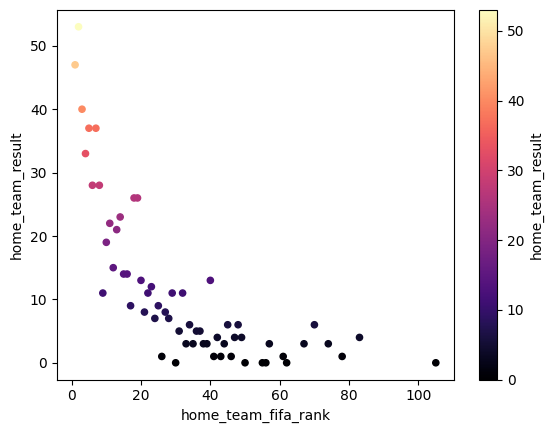

In [134]:
# pull out rows and columns by name
(fifa
 .set_index('tournament')
 .sort_index()
 .loc[['FIFA World Cup'], ['home_team_fifa_rank','home_team_result']]
 .assign(home_team_result = lambda df: df.home_team_result.map({'Lose':0,'Draw':1,'Win':3}).astype(int))
#  .info()
 .groupby(by='home_team_fifa_rank').agg({'home_team_fifa_rank':'mean','home_team_result':'sum'})
 .plot.scatter(x='home_team_fifa_rank',y='home_team_result', c='home_team_result',cmap='magma')
)


In [138]:
# pull out rows and columns by name
(fifa
 .dropna(axis=0)
 .set_index('home_team')
 .sort_index()
 .iloc[:2, -2:]
)


,away_team_mean_offense_score,away_team_mean_midfield_score
home_team,,
Albania,83.7,84.2
Albania,72.7,73.0
